In [1]:
!pip install d2l==0.15.1
!pip install -U mxnet-cu101==1.7.0


     |████████████████████████████████| 61kB 3.3MB/s 
     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:11tcmalloc: large alloc 1147494400 bytes == 0x65782000 @  0x7fa04a868615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 22kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
from d2l import mxnet as d2l
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [3]:
def corr1d(X, K):
    w = K.shape[0]
    Y = np.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

In [4]:
X, K = np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 2])
corr1d(X, K)

array([ 2.,  5.,  8., 11., 14., 17.])

In [5]:
def corr1d_multi_in(X, K):
   
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = np.array([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = np.array([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

array([ 2.,  8., 14., 20., 26., 32.])

In [7]:
class TextCNN(nn.Block):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(2)
        self.pool = nn.GlobalMaxPool1D()
        self.convs = nn.Sequential()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.add(nn.Conv1D(c, k, activation='relu'))

    def forward(self, inputs):
      
        embeddings = np.concatenate((
            self.embedding(inputs), self.constant_embedding(inputs)), axis=2)
 
        embeddings = embeddings.transpose(0, 2, 1)
    
        encoding = np.concatenate([
            np.squeeze(self.pool(conv(embeddings)), axis=-1)
            for conv in self.convs], axis=1)
     
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [12]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [200, 200, 200]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
net.initialize(init.Xavier(), ctx=devices)

In [13]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.set_data(embeds)
net.constant_embedding.weight.set_data(embeds)
net.constant_embedding.collect_params().setattr('grad_req', 'null')

loss 0.063, train acc 0.980, test acc 0.868
4033.3 examples/sec on [gpu(0)]


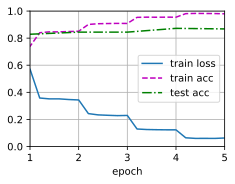

In [14]:
lr, num_epochs = 0.001, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)